In [119]:
import tensorflow as tf
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
import json

In [120]:
route_dataset_model = "dataset_for_modelo.xlsx"
dataset = pd.read_excel(route_dataset_model)

list_of_main_ingredients=['Yuca', 'Huevo', 'Pollo', 'Carne', 'Choclo', 'Lomo', 'Pescado', 'Cuy', 'Papa', 'Pasta', 'Camote', 'Papas Fritas', 'Camarones', 'Cerdo', 'Arroz', 'Langostinos', 'Mondongo', 'Frijoles', 'Carne Molida']

#Delete unnecessary column
dataset = dataset.drop('Total imp. ingredients result (g)', axis=1) 

#Convert to array
dataset['F.D. List(Important Ingredient/Portion)'] = dataset['F.D. List(Important Ingredient/Portion)'].apply(ast.literal_eval)
dataset['F.D. List Result(Important Ingredient/Portion)'] = dataset['F.D. List Result(Important Ingredient/Portion)'].apply(ast.literal_eval)

In [121]:
#Transform into an array of percentages
array_percentage = []

for i in range(dataset.shape[0]):
    arr = []
    for j in range(len(list_of_main_ingredients)):
        check = False
        for k in dataset['F.D. List(Important Ingredient/Portion)'][i]:
            if list_of_main_ingredients[j] == k[0]:
                arr.append(int(k[1]))
                check = True
                break
        if not check:
            arr.append(0)

    suma = sum(arr)
    if suma > 0:
        arr = [x / suma for x in arr]

    array_transformado = [round(num, 2) for num in arr]
    
    diferencia = 1.0 - sum(array_transformado)
    
    for i in range(len(array_transformado)):
        if array_transformado[i] + diferencia >= 0:
            array_transformado[i] += diferencia
            break

    array_percentage.append(array_transformado)

array_result = []

for i in range(dataset.shape[0]):
    arr = []
    for j in range(len(list_of_main_ingredients)):
        check = False
        for k in dataset['F.D. List Result(Important Ingredient/Portion)'][i]:
            if list_of_main_ingredients[j] == k[0]:
                arr.append(int(k[1]))
                check = True
                break
        if not check:
            arr.append(0)

    suma = sum(arr)
    if suma > 0:
        arr = [x / suma for x in arr]

    array_transformado = [round(num, 2) for num in arr]
    
    diferencia = 1.0 - sum(array_transformado)
    
    for i in range(len(array_transformado)):
        if array_transformado[i] + diferencia >= 0:
            array_transformado[i] += diferencia
            break

    array_result.append(array_transformado)

#Delete and add new columns
dataset = dataset.drop('F.D. List(Important Ingredient/Portion)', axis=1) 
dataset = dataset.drop('F.D. List Result(Important Ingredient/Portion)', axis=1) 
dataset['F.D. %List(Important Ingredient/Portion)']=array_percentage
dataset['F.D. %List Result(Important Ingredient/Portion)']=array_result

In [122]:
#Decomposing into new columns
expanded_columns = pd.DataFrame(dataset["F.D. %List(Important Ingredient/Portion)"].tolist(), columns=[f"Ingredient_{i+1}" for i in range(19)])
dataset = pd.concat([dataset, expanded_columns], axis=1)
dataset.drop("F.D. %List(Important Ingredient/Portion)", axis=1, inplace=True)

expanded_columns2 = pd.DataFrame(dataset["F.D. %List Result(Important Ingredient/Portion)"].tolist(), columns=[f"Result_{i+1}" for i in range(19)])
dataset = pd.concat([dataset, expanded_columns2], axis=1)
dataset.drop("F.D. %List Result(Important Ingredient/Portion)", axis=1, inplace=True)

In [123]:
dataset.to_excel("wee.xlsx", index=False)

In [124]:
columns_to_scale = [
    "P. Carbohydrates required",
    "P. Protein required",
    "P. Total fat required",
    "N° Food dish",
    "F.D. Portion (g)",
    "F.D. Carbohydrates (g)",
    "F.D. Protein (g)",
    "F.D. Total fat (g)"
]
scaler = MinMaxScaler()
dataset[columns_to_scale] = scaler.fit_transform(dataset[columns_to_scale])
dataset[columns_to_scale] = dataset[columns_to_scale].round(2)

#create metrics
MSE=[]
RMSE=[]
MAE=[]
R_2=[]

In [125]:
X = dataset.drop(['Result_1','Result_2','Result_3','Result_4','Result_5','Result_6','Result_7','Result_8','Result_9','Result_10','Result_11','Result_12','Result_13','Result_14','Result_15','Result_16','Result_17','Result_18','Result_19'], axis=1)
Y = dataset[['Result_1','Result_2','Result_3','Result_4','Result_5','Result_6','Result_7','Result_8','Result_9','Result_10','Result_11','Result_12','Result_13','Result_14','Result_15','Result_16','Result_17','Result_18','Result_19']]

X_train = X.iloc[:250]
X_test = X.iloc[250:]
y_train = Y.iloc[:250]
y_test = Y.iloc[250:]

Train and test with MLP

In [126]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(304, activation='relu', input_shape=(27,)), 
    tf.keras.layers.Dense(152, activation='relu'),    
    tf.keras.layers.Dense(76, activation='relu'),  
    tf.keras.layers.Dense(38, activation='relu'),   
    tf.keras.layers.Dense(19, activation='softmax')                  
])

model.compile(optimizer='adam', loss='mean_squared_error', 
              metrics=['mean_squared_error'])

model.fit(X_train, y_train, epochs=1000, batch_size=16)

Epoch 1/1000


C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0191 - mean_squared_error: 0.0191
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162 - mean_squared_error: 0.0162 
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116 - mean_squared_error: 0.0116 
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089 - mean_squared_error: 0.0089 
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0083 - mean_squared_error: 0.0083 
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 - mean_squared_error: 0.0073 
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - mean_squared_error: 0.0060 
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - mean_squared_error: 0.0053 
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049 - mean_squared_error: 0.0049 
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045 
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

In [127]:
y_pred_test = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
#
MSE.append(mse)
RMSE.append(rmse)
MAE.append(mae)
R_2.append(r2)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


**Regresion Lineal**

In [128]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
#
y_pred_test = lin_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
#
MSE.append(mse)
RMSE.append(rmse)
MAE.append(mae)
R_2.append(r2)

**Regresion Ridge**

In [129]:
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)
#
y_pred_test = ridge_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
#
MSE.append(mse)
RMSE.append(rmse)
MAE.append(mae)
R_2.append(r2)

**Máquina de Soporte Vectorial (SVR)**

In [130]:
svr = SVR(kernel='rbf')
multi_svr = MultiOutputRegressor(svr)
multi_svr.fit(X_train, y_train)
#
y_pred_test = multi_svr.predict(X_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
#
MSE.append(mse)
RMSE.append(rmse)
MAE.append(mae)
R_2.append(r2)

**Random Forest Regressor**

In [131]:
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf=10)
rf_reg.fit(X_train, y_train)
#
y_pred_test = rf_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
#
MSE.append(mse)
RMSE.append(rmse)
MAE.append(mae)
R_2.append(r2)

**Gradient Boosting Regressor**

In [132]:
gbr = GradientBoostingRegressor(n_estimators=100, max_depth=20, min_samples_leaf=10)
multi_gbr = MultiOutputRegressor(gbr)
multi_gbr.fit(X_train, y_train)
#
y_pred_test = multi_gbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
#
MSE.append(mse)
RMSE.append(rmse)
MAE.append(mae)
R_2.append(r2)

Comparison of models for the First part

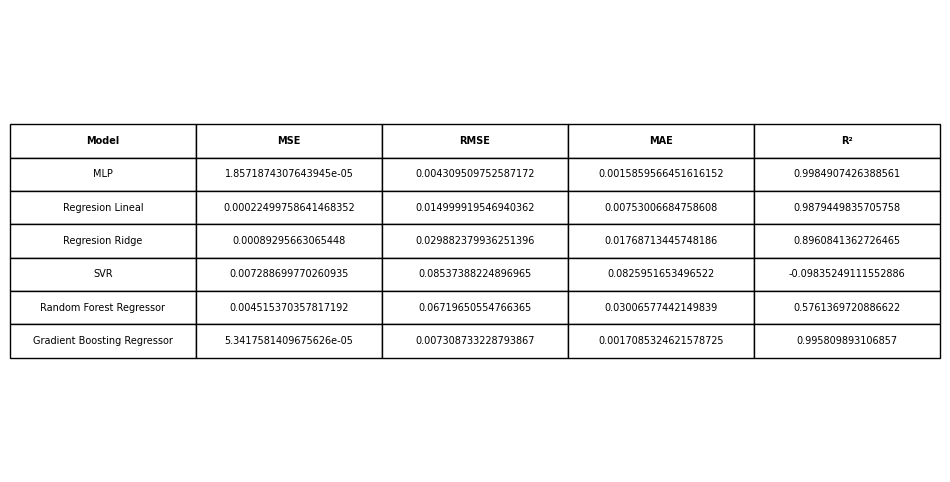

In [133]:
data = {
    'Model': ['MLP', 'Regresion Lineal', 'Regresion Ridge', 'SVR', 'Random Forest Regressor', 'Gradient Boosting Regressor'],
    'MSE': [MSE[0], MSE[1], MSE[2], MSE[3],MSE[4], MSE[5]],
    'RMSE': [RMSE[0], RMSE[1], RMSE[2], RMSE[3],RMSE[4], RMSE[5]],
    'MAE': [MAE[0], MAE[1], MAE[2], MAE[3],MAE[4], MAE[5]],
    'R²': [R_2[0], R_2[1], R_2[2], R_2[3],R_2[4], R_2[5]],
}

df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(12, 6))

ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

table.scale(1, 2)

for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_text_props(weight='bold')

plt.show()

Export the model and its scaler

In [134]:
scaler_params = {
    'data_min_': scaler.data_min_.tolist(),
    'data_max_': scaler.data_max_.tolist()
}

with open('modelos/model1/scaler_params.json', 'w') as f:
    json.dump(scaler_params, f)

In [135]:
model.save('modelos/model1/saved_model1.h5')